In [1]:
import numpy as np
import torch
from torch.amp import autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import map2map
from map2map.data import norms, subbox
from map2map import models
from map2map.models.nbody_d2d import NbodyD2DStyledVNet
from map2map.utils import load_model_state_dict

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from map2map.models.narrow import narrow_by
from typing import Optional, Tuple

class LeakyReLUStyled(nn.Module):
    def __init__(self, negative_slope: float = 0.01, inplace: bool = False):
        super(LeakyReLUStyled, self).__init__()
        self.negative_slope = negative_slope
        self.inplace = inplace

    @torch.jit.export
    def forward(self, x: torch.Tensor, s: Optional[torch.Tensor] = None) -> torch.Tensor:
        return F.leaky_relu(x, negative_slope=self.negative_slope, inplace=self.inplace)

class StyleBase3d(nn.Module):
    def __init__(self, style_size: int, in_chan: int, out_chan: int, hidden_size: int, kernel_size: int, stride: int, spatial_in_shape: Tuple[int],
         spatial_out_shape: Tuple[int], transpose: bool, eps: float = 1e-8):
        super().__init__()

        self.style_size = style_size
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.hidden_size = hidden_size
        self.K3 = (kernel_size,) * 3
        self.stride = stride
        self.spatial_in_shape = spatial_in_shape
        self.spatial_out_shape = spatial_out_shape
        self.N = spatial_in_shape[0]
        self.Cin = spatial_in_shape[1]
        self.DHWin = spatial_in_shape[2:]
        self.DHWout = spatial_out_shape[2:]
        self.eps = eps

        #self.style_mlp = nn.Sequential(
        #    nn.Linear(self.style_size, self.hidden_size),
        #    nn.LeakyReLU(),
        #    nn.Linear(self.hidden_size, self.hidden_size),
        #    nn.LeakyReLU(),
        #    nn.Linear(self.hidden_size, self.in_chan)
        #)
        #for layer in self.style_mlp :
        #    if isinstance(layer, nn.Linear) :
        #        nn.init.kaiming_uniform_(layer.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')

        self.style_weight = nn.Parameter(torch.empty(in_chan, style_size))
        nn.init.kaiming_uniform_(self.style_weight, a=math.sqrt(5),
                                 mode='fan_in', nonlinearity='leaky_relu')
        self.style_bias = nn.Parameter(torch.ones(in_chan))
       
        if transpose :
            self.style_reshape = (self.N, self.Cin, 1, 1, 1, 1)
            self.fan_in_dim = (1, 3, 4, 5)
            self.conv = F.conv_transpose3d
            self.weight = nn.Parameter(torch.empty(self.in_chan, self.out_chan, *self.K3))
        else :
            self.style_reshape = (self.N, 1, self.Cin, 1, 1, 1)
            self.fan_in_dim = (2, 3, 4, 5)
            self.conv = F.conv3d
            self.weight = nn.Parameter(torch.empty(self.out_chan, self.in_chan, *self.K3))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')

        self.bias = nn.Parameter(torch.zeros(out_chan))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

        self.w_reshape = (self.N * self.out_chan, self.in_chan, self.K3[0], self.K3[1], self.K3[2])
        self.x_reshape = (self.N, self.out_chan, self.DHWout[0], self.DHWout[1], self.DHWout[2]) 
            
    @torch.jit.export
    def forward(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor :
        
        #s = self.style_mlp(s)
        s = F.linear(s, self.style_weight, bias=self.style_bias)
        s = s.reshape(self.style_reshape)
        w = self.weight * s
        w = w * torch.rsqrt(w.pow(2).sum(dim=self.fan_in_dim, keepdim=True) + self.eps)
        
        w = w.reshape(self.w_reshape)
        x = x.reshape(1, self.N * self.Cin, self.DHWin[0], self.DHWin[1], self.DHWin[2])
        x = self.conv(x, w, bias=self.bias, stride=self.stride, groups=self.N)
        x = x.reshape(self.x_reshape)

        return x

class StyleConv3d(StyleBase3d):
    def __init__(self, style_size: int, in_chan: int, out_chan: int, hidden_size: int, spatial_in_shape: Tuple[int], eps: float = 1e-8):

        kernel_size = 3
        stride = 1
        spatial_out_shape = tuple(s - 2 if i > 1 else s for i, s in enumerate(spatial_in_shape))
        transpose = False

        super(StyleConv3d, self).__init__(style_size, in_chan, out_chan, hidden_size, kernel_size, stride, spatial_in_shape, spatial_out_shape, transpose, eps)
        
class StyleSkip3d(StyleBase3d):
    def __init__(self, style_size: int, in_chan: int, out_chan: int, hidden_size: int, spatial_in_shape: Tuple[int], eps: float = 1e-8):

        kernel_size = 1
        stride = 1
        spatial_out_shape = spatial_in_shape
        transpose = False

        super(StyleSkip3d, self).__init__(style_size, in_chan, out_chan, hidden_size, kernel_size, stride, spatial_in_shape, spatial_out_shape, transpose, eps)

class StyleDownSample3d(StyleBase3d):
    def __init__(self, style_size: int, in_chan: int, out_chan: int, hidden_size: int, spatial_in_shape: Tuple[int], eps: float = 1e-8):

        kernel_size = 2
        stride = 2
        spatial_out_shape = tuple(s // 2 if i > 1 else s for i, s in enumerate(spatial_in_shape))
        transpose = False

        super(StyleDownSample3d, self).__init__(style_size, in_chan, out_chan, hidden_size, kernel_size, stride, spatial_in_shape, spatial_out_shape, transpose, eps)
                    
class StyleUpSample3d(StyleBase3d):
    def __init__(self, style_size: int, in_chan: int, out_chan: int, hidden_size: int, spatial_in_shape: Tuple[int], eps: float = 1e-8):

        kernel_size = 2
        stride = 2
        spatial_out_shape = tuple(s * 2 if i > 1 else s for i, s in enumerate(spatial_in_shape))
        transpose = True

        super(StyleUpSample3d, self).__init__(style_size, in_chan, out_chan, hidden_size, kernel_size, stride, spatial_in_shape, spatial_out_shape, transpose, eps)

        
class StyleResampleBlock3d(nn.Module) :
    
    def __init__(self, seq: str, style_size: int, in_chan: int, out_chan: int, spatial_in_shape: Tuple[int]) :
        
        super().__init__()
        
        self.seq = seq
        self.style_size = style_size
        self.in_chan = in_chan
        self.out_chan = out_chan
        
        layer_spatial_in_shape = spatial_in_shape
        mid_chan = max(in_chan, out_chan)
        layers = []
        for idx_conv, l in enumerate(seq) :
            in_chan = out_chan = mid_chan
            if idx_conv == 0 :
                in_chan = self.in_chan
            if idx_conv == len(self.seq) - 1 :
                out_chan = self.out_chan
            layer_spatial_in_shape = tuple(in_chan if i == 1 else s for i, s in enumerate(layer_spatial_in_shape))
            if l == 'U':
                layer = StyleUpSample3d(self.style_size, in_chan, out_chan, 2 * self.style_size, layer_spatial_in_shape)
                layer_spatial_in_shape = layer.spatial_out_shape
            elif l == 'D':
                layer = StyleDownSample3d(self.style_size, in_chan, out_chan, 2 * self.style_size, layer_spatial_in_shape)
                layer_spatial_in_shape = layer.spatial_out_shape
            elif l == 'A':
                layer = LeakyReLUStyled()
            else :
                raise ValueError('layer type {} not supported'.format(l))
            layers.append(layer)
            
        self.convs = nn.ModuleList(layers)
        self.spatial_out_shape = layer_spatial_in_shape
              
    @torch.jit.export
    def forward(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor :
        for l in self.convs :
            x = l(x,s)
        return x

class StyleResNetBlock3d(nn.Module) :
    def __init__(self, seq: str, style_size: int, in_chan: int, out_chan: int, spatial_in_shape: Tuple[int], last_act: bool) :
        super().__init__()
                    
        self.style_size = style_size
        self.seq = seq
        self.in_chan = in_chan
        self.out_chan = out_chan
                
        layer_spatial_in_shape = spatial_in_shape
        mid_chan = max(in_chan, out_chan)
        layers = []
        for idx_conv, l in enumerate(seq) :
            in_chan = out_chan = mid_chan
            if idx_conv == 0 :
                in_chan = self.in_chan
            if idx_conv == len(self.seq) - 1 :
                out_chan = self.out_chan
            layer_spatial_in_shape = tuple(in_chan if i == 1 else s for i, s in enumerate(layer_spatial_in_shape))
            if l == 'C':
                layer = StyleConv3d(self.style_size, in_chan, out_chan, 2 * self.style_size, layer_spatial_in_shape)
                layer_spatial_in_shape = layer.spatial_out_shape
            elif l == 'A':
                layer = LeakyReLUStyled()
            else :
                raise ValueError('layer type {} not supported'.format(l))
            layers.append(layer)
            
        self.convs = nn.ModuleList(layers)
        self.spatial_out_shape = layer_spatial_in_shape
        self.skip = StyleSkip3d(style_size, self.in_chan, self.out_chan, 2 * self.style_size, spatial_in_shape)
        self.num_conv = sum([seq.count(l) for l in ['C']])
                
        if last_act :
            self.act = LeakyReLUStyled()
        else :
            self.act = None

    @torch.jit.export
    def forward(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor :
        y = self.skip(x, s)
        y = y[:,:,self.num_conv:-self.num_conv,self.num_conv:-self.num_conv,self.num_conv:-self.num_conv]
        for l in self.convs :
            x = l(x, s)
        x = x + y
        if self.act is not None :
            x = self.act(x)
        return x

In [3]:
class ScriptStyledVNet(nn.Module):
    def __init__(self, style_size, in_chan: int, out_chan: int, spatial_in_shape: Tuple[int]) :
        """V-Net like network with styles

        See `vnet.VNet`.
        """
        super().__init__()

        self.conv_l00 = StyleResNetBlock3d('CAC', style_size, in_chan, 64, spatial_in_shape, True)
        self.conv_l01 = StyleResNetBlock3d('CAC', style_size, 64, 64, self.conv_l00.spatial_out_shape, True)
        self.down_l0 = StyleResampleBlock3d('DA', style_size, 64, 64, self.conv_l01.spatial_out_shape)
        self.conv_l1 = StyleResNetBlock3d('CAC', style_size, 64, 64, self.down_l0.spatial_out_shape, True)
        self.down_l1 = StyleResampleBlock3d('DA', style_size, 64, 64, self.conv_l1.spatial_out_shape)
        self.conv_l2 = StyleResNetBlock3d('CAC', style_size, 64, 64, self.down_l1.spatial_out_shape, True)
        self.down_l2 = StyleResampleBlock3d('DA', style_size, 64, 64, self.conv_l2.spatial_out_shape)
        self.conv_c = StyleResNetBlock3d('CAC', style_size, 64, 64, self.down_l2.spatial_out_shape, True)
        self.up_r2 = StyleResampleBlock3d('UA', style_size, 64, 64, self.conv_c.spatial_out_shape)
        spatial_in_shape = tuple(128 if i == 1 else s for i, s in enumerate(self.up_r2.spatial_out_shape))
        self.conv_r2 = StyleResNetBlock3d('CAC', style_size, 128, 64, spatial_in_shape, True)
        self.up_r1 = StyleResampleBlock3d('UA', style_size, 64, 64, self.conv_r2.spatial_out_shape)
        spatial_in_shape = tuple(128 if i == 1 else s for i, s in enumerate(self.up_r1.spatial_out_shape))
        self.conv_r1 = StyleResNetBlock3d('CAC', style_size, 128, 64, spatial_in_shape, True)
        self.up_r0 = StyleResampleBlock3d('UA', style_size, 64, 64, self.conv_r1.spatial_out_shape)
        spatial_in_shape = tuple(128 if i == 1 else s for i, s in enumerate(self.up_r0.spatial_out_shape))
        self.conv_r00 = StyleResNetBlock3d('CAC', style_size, 128, 64, spatial_in_shape, True)
        spatial_in_shape = tuple(64 if i == 1 else s for i, s in enumerate(self.conv_r00.spatial_out_shape))
        self.conv_r01 = StyleResNetBlock3d('CAC', style_size, 64, out_chan, spatial_in_shape, False)

    @torch.jit.export
    def forward(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor:

        rescale = torch.sum(s * torch.tensor([0.,1.]).to(s.device) + torch.tensor([0.,1.]).to(s.device))
        x = x * rescale
        
        x0 = x[:,:,48:-48,48:-48,48:-48]

        x = self.conv_l00(x, s)
        y0 = self.conv_l01(x, s)
        x = self.down_l0(y0, s)
        y0 = y0[:,:,40:-40,40:-40,40:-40]

        y1 = self.conv_l1(x, s)
        x = self.down_l1(y1, s)
        y1 = y1[:,:,16:-16,16:-16,16:-16]

        y2 = self.conv_l2(x, s)
        x = self.down_l2(y2, s)
        y2 = y2[:,:,4:-4,4:-4,4:-4]

        x = self.conv_c(x, s)
        x = self.up_r2(x, s)
        x = torch.cat([y2, x], dim=1)

        del y2

        x = self.conv_r2(x, s)
        x = self.up_r1(x, s)
        x = torch.cat([y1, x], dim=1)

        del y1

        x = self.conv_r1(x, s)
        x = self.up_r0(x, s)
        x = torch.cat([y0, x], dim=1)

        del y0

        x = self.conv_r00(x, s)
        x = self.conv_r01(x, s)

        x = x + x0
        del x0
            
        return x

In [4]:
#
# Box and subbox setup
#
size = (512,) * 3               # Size of the total box, number of grid site along each dimension
padding = ((48,)*2,)*3          # Padding, must be 48 cells on each side of the subbox
ndiv = (4,) * 3                 # Number of subbox divisios along each dimesion, 4 means subboxes of size 128^3
num_subboxes = np.prod(ndiv)    # Total number of subboxes to process

#
# Model initialization
#

device = torch.device(f'cuda') # Either 'cuda' or 'cpu'

style_size = 2    # Must be 2: [Omega_m, D(z)]
in_chan = 3       # Must be 3 input channels: displacement components
out_chan = 3      # Must be 3 output channels: displacement components
spatial_in_shape = (1, in_chan,) + tuple(s // d + np.sum(p) for d, s, p in zip(ndiv, size, padding))


#
# Initialize the model
#
model = ScriptStyledVNet(style_size, in_chan, out_chan, spatial_in_shape)
model.to(device);

#
# Load the model parameters
#
state = torch.load('../Map2Map/map2map/model_parameters/nbody_params.pt')
load_model_state_dict(model, state['model'], strict=True)

#
# Initialize the subbox object
#
#sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)

FileNotFoundError: [Errno 2] No such file or directory: '../Map2Map/map2map/model_parameters/nbody_params.pt'

In [5]:
'''
    Load the numpy arrays for the input and target
    
    Datasets:
    --------
    
    input: numpy.array
        (3,size,size,size) array of ZA displacements at redshift z=0
    dis_tgt: numpy.array
        (3,size,size,size) array of nonlinear displacements at target redshift from nbody simulation
    vel_tgt: numpy.array
        (3,size,size,size) array of nonlinear peculiar velocities at target redshift from nbody simulation
    param: numpy.array
        (6,) array of cosmology parameters and redshift (Omega_m, Omega_b, h, n_s, sigma_8, z)

'''

input = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Linear/Fiducial/5/dis.npy')).float()
dis_tgt = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Nonlinear/Fiducial/5/dis.npy')).float()
vel_tgt = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Nonlinear/Fiducial/5/vel.npy')).float()
param = np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Linear/Fiducial/5/params.npy')


Om = float(param[0])   # Omega_m
z = float(param[-1])   # redhist

# Normalize the input with variance ~= 1
norms.cosmology.dis(input) 

# Compute linear growth factor and initialize style inputs as torch.tensor
Dz = norms.cosmology.D(z, Om)
Dz = torch.tensor([Dz]).float().to(device)
Om = torch.tensor([Om]).float().to(device)

# Construct the style parameters
s0 = (Om - 0.3) * 5.
s1 = (Dz - 1.)
s = torch.cat((s0.unsqueeze(0), s1.unsqueeze(0)), dim=1).squeeze(0)

In [6]:
sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)
with torch.no_grad() :
    with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
        for crop in tqdm(range(num_subboxes)) :
            sb.forward(input, s, indx=crop, compile = False)
norms.cosmology.dis(sb.dis_out, undo=True)

100%|██████████| 64/64 [00:25<00:00,  2.47it/s]


In [8]:
#sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)
with torch.no_grad() :
    sb.dis_out *= 0.
    with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
        for crop in tqdm(range(num_subboxes)) :
            sb.forward(input, s, indx=crop, compile = True)
norms.cosmology.dis(sb.dis_out, undo=True)

100%|██████████| 64/64 [00:25<00:00,  2.54it/s]


In [9]:
sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)
with torch.no_grad() :
    sb.vel_out *= 0.
    sb.vel_out *= 0.
    with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
        for crop in tqdm(range(num_subboxes)) :
            sb.forward_jvp(input, s, indx=crop, compile = False)
norms.cosmology.dis(sb.dis_out, undo=True)
norms.cosmology.vel(sb.vel_out, undo=True, Om=Om.cpu(), z=z)

100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


In [15]:
#
# Loop over subboxes and normalize the output
#
#sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)
with torch.no_grad() :
    sb.dis_out *= 0.
    sb.vel_out *= 0.
    with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
        for crop in tqdm(range(num_subboxes)) :
            sb.forward_jvp(input, s, indx=crop, compile = True)
norms.cosmology.dis(sb.dis_out, undo=True)
norms.cosmology.vel(sb.vel_out, undo=True, Om=Om.cpu(), z=z)

100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


In [16]:
#
# Displacement statistics
#
print(dis_tgt.min(), dis_tgt.max(), sb.dis_out.min(), sb.dis_out.max(), torch.std(dis_tgt - sb.dis_out))

tensor(-23.7753) tensor(26.2173) tensor(-23.2323) tensor(26.1029) tensor(0.1627)


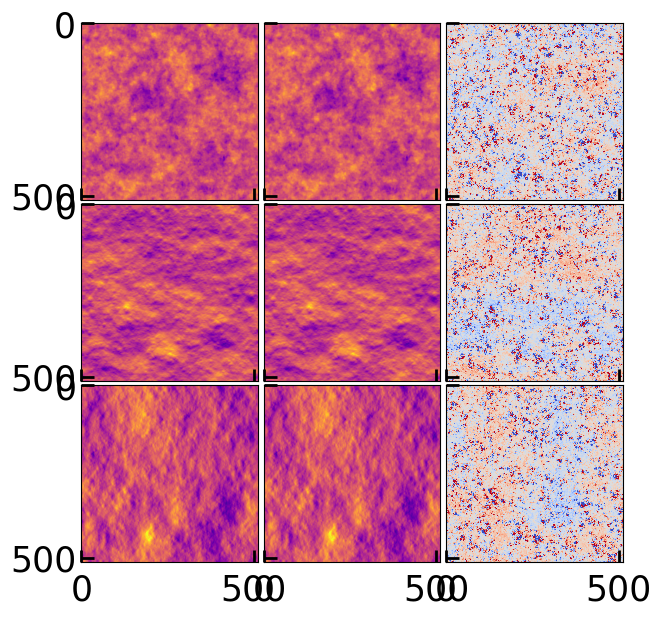

In [17]:
#
# Displacement plots
#
%matplotlib inline

fig, axs = plt.subplots(3, 3, figsize = (7,7), sharex = True, sharey=True)
plt.subplots_adjust(hspace = 0.025, wspace = 0.025)

cmap = plt.get_cmap('plasma', 256)
norm = plt.Normalize(-20, 20)
cmap2 = plt.get_cmap('coolwarm', 256)
norm2 = plt.Normalize(-0.1, 0.1)

for d in range(3) :
    axs[d, 0].imshow(sb.dis_out[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 1].imshow(dis_tgt[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 2].imshow(sb.dis_out[d,0,:,:] - dis_tgt[d,0,:,:], cmap = cmap2, norm = norm2)

In [18]:
#
# Velocity statistics
#
print(vel_tgt.min(), vel_tgt.max(), sb.vel_out.min(), sb.vel_out.max(), torch.std(vel_tgt - sb.vel_out))

tensor(-4190.0723) tensor(3989.7776) tensor(-4025.5576) tensor(3647.3616) tensor(125.1332)


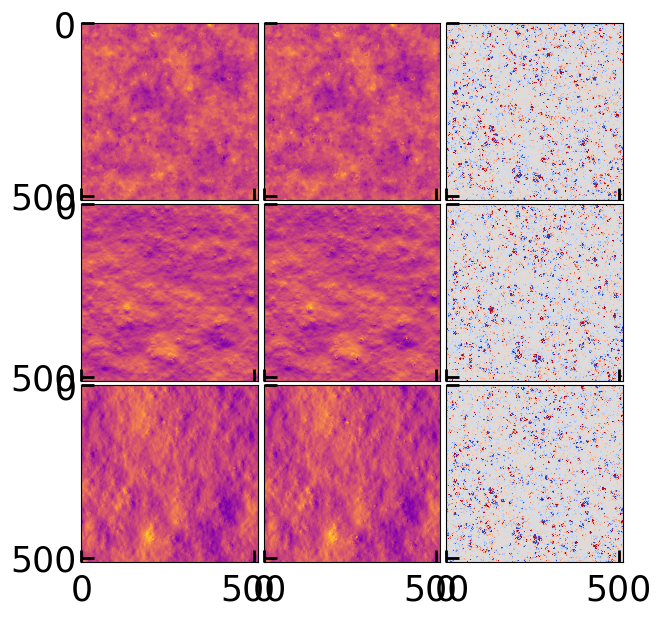

In [19]:
#
# Velocity plots
#
%matplotlib inline

fig, axs = plt.subplots(3, 3, figsize = (7,7), sharex = True, sharey=True)
plt.subplots_adjust(hspace = 0.025, wspace = 0.025)

cmap = plt.get_cmap('plasma', 256)
norm = plt.Normalize(-2000, 2000)
cmap2 = plt.get_cmap('coolwarm', 256)
norm2 = plt.Normalize(-100, 100)

for d in range(3) :
    axs[d, 0].imshow(sb.vel_out[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 1].imshow(vel_tgt[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 2].imshow(sb.vel_out[d,0,:,:] - vel_tgt[d,0,:,:], cmap = cmap2, norm = norm2)

In [2]:
#
# Model initialization
#

device = torch.device(f'cuda') # Either 'cuda' or 'cpu'

style_size = 2    # Must be 2: [Omega_m, D(z)]
in_chan = 3       # Must be 3 input channels: displacement components
out_chan = 3      # Must be 3 output channels: displacement components

#
# Initialize the model
#
model = NbodyD2DStyledVNet(style_size, in_chan, out_chan)
model.to(device);

#
# Load the model parameters
#
state = torch.load('../map2map/model_parameters/nbody_params.pt')
load_model_state_dict(model, state['model'], strict=True)

In [3]:
#
# Box and subbox setup
#

size = (512,) * 3               # Size of the total box, number of grid site along each dimension
padding = ((48,)*2,)*3          # Padding, must be 48 cells on each side of the subbox
ndiv = (4,) * 3                 # Number of subbox divisios along each dimesion, 4 means subboxes of size 128^3
num_subboxes = np.prod(ndiv)    # Total number of subboxes to process

#
# Initialize the subbox object
#
sb = subbox.Subbox(model, in_chan, size, ndiv, padding, device)

In [4]:
'''
    Load the numpy arrays for the input and target
    
    Datasets:
    --------
    
    input: numpy.array
        (3,size,size,size) array of ZA displacements at redshift z=0
    dis_tgt: numpy.array
        (3,size,size,size) array of nonlinear displacements at target redshift from nbody simulation
    vel_tgt: numpy.array
        (3,size,size,size) array of nonlinear peculiar velocities at target redshift from nbody simulation
    param: numpy.array
        (6,) array of cosmology parameters and redshift (Omega_m, Omega_b, h, n_s, sigma_8, z)

'''

#
# These filenames should be replaced with local file names
#
input = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Linear/Fiducial/5/dis.npy')).float()
dis_tgt = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Nonlinear/Fiducial/5/dis.npy')).float()
vel_tgt = torch.tensor(np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Nonlinear/Fiducial/5/vel.npy')).float()
param = np.load('/mnt/ceph/users/ajamieson/Quijote/ManySnaps/Corners/Linear/Fiducial/5/params.npy')


Om = float(param[0])   # Omega_m
z = float(param[-1])   # redhist

# Normalize the input with variance ~= 1
norms.cosmology.dis(input) 

# Compute linear growth factor and initialize style inputs as torch.tensor
Dz = norms.cosmology.D(z, Om)
Dz = torch.tensor([Dz]).float().to(device)
Om = torch.tensor([Om]).float().to(device)

In [15]:
import torch
import numpy as np
import torch.func as func
from functorch import make_fx
from typing import Callable, Optional, Tuple

class Subbox :
    """
    A class to handle sub-box operations for map2map forward modeling.

    Attributes
    ----------
    model : callable
        The model function to evaluate.
    jvp_dir : torch.Tensor
        The direction vector for the Jacobian-vector product derivative.
    size : tuple
        The size of the box (number of grid sites along each dimension).
    ndiv : tuple
        The number of subbox divisions in each dimension.
    device : torch.device
        The device to perform computations on.
    pad : tuple
        The padding to be applied to each side of each dimension.
    crop_inds : tuple or None
        The indices for cropping the sub-box from the full box.
    dis_out : torch.Tensor
        The output tensor for displacement.
    vel_out : torch.Tensor
        The output tensor for velocity. 
    
    Methods
    -------
    setCrop(indx)
        Sets the crop indices for the sub-box.
    getCropInds(anchor, crop, pad, size)
        Computes the crop indices for the sub-box.
    forward(input, Om, Dz, indx=None)
        Performs the forward pass of the model on the sub-box.
    """

    NDIM = 3  # Number of dimensions

    def __init__(self, model: Callable, in_chan: int, size: Tuple[int, int, int], ndiv: Tuple[int, int, int], 
                 padding: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]], device: str, indx: Optional[int] = None):
        """
        Initializes the Subbox instance.

        Parameters
        ----------
        model : callable
            The model function to evaluate.
        in_chan : int
            The number of the input channels.
        size : tuple
            The size of the box (number of grid sites along each dimension).
        ndiv : tuple
            The number of subbox divisions in each dimension.
        padding : tuple
            The padding to be applied to each side of each dimension.
        device : torch.device
            The device to perform computations on.
        indx : int, optional
            The index of the subbox (default is None).
        """
        self.model = model
        self.device = device
        self.first_round = True
        self.first_jvp_round = True
        
        self.size = size
        self.ndiv = ndiv
        self.pad = padding
        
        spatial_in_shape = (1, in_chan,) + tuple(s // d + np.sum(p) for d, s, p in zip(ndiv, size, padding))
        #self.jvp_dir = torch.tensor([0, 1.]).float().to(device)
        self.jvp_dir = torch.tensor([1.], device=device)        
        #self.jvp_dir = (torch.zeros(spatial_in_shape).float().to(device), torch.tensor([0, 1.]).float().to(device))    
        
        self.crop_inds = None
        if indx is not None:
            self.setCrop(indx)
                    
        self.dis_out = torch.zeros(self.NDIM, *size, device='cpu', dtype=torch.float32)
        self.vel_out = torch.zeros(self.NDIM, *size, device='cpu', dtype=torch.float32)

    def setCrop(self, indx: int) -> None:
        """
        Sets the crop indices for the subbox.

        Parameters
        ----------
        indx : int
            The index of the subbox.
        """
        crop = tuple(s // d for s, d in zip(self.size, self.ndiv))
        anchor = (
            (indx // self.ndiv[1] // self.ndiv[2]) * (self.size[0] // self.ndiv[0]),
            ((indx // self.ndiv[1]) % self.ndiv[2]) * (self.size[1] // self.ndiv[1]),
            ((indx % self.ndiv[1]) % self.ndiv[2]) * self.size[2] // self.ndiv[2]
        )
        self.crop_inds = self.getCropInds(anchor, crop, self.pad, self.size)
        self.add_inds = self.getCropInds(anchor, crop, ((0,)*2,)*self.NDIM, self.size)

    def getCropInds(self, anchor: Tuple[int, int, int], crop: Tuple[int, int, int], 
                    pad: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]], 
                    size: Tuple[int, int, int]) -> Tuple[slice, ...]:
        """
        Computes the crop indices for the subbox.

        Parameters
        ----------
        anchor : tuple
            The anchor point for the crop.
        crop : tuple
            The size of the crop.
        pad : tuple
            The padding to be applied to each dimension.
        size : tuple
            The size of the full box.

        Returns
        -------
        Tuple[slice, ...]
            The computed crop indices.
        """        
        ind = [slice(None)]
        for d, (a, c, (p0, p1), s) in enumerate(zip(anchor, crop, pad, size)):
            start = a - p0
            end = a + c + p1
            i = np.arange(start, end) % s
            ind.append(i.reshape((-1,) + (1,) * (self.NDIM - d - 1)))        
        return tuple(ind)

    def forward(self, input: torch.Tensor, Om: torch.Tensor, Dz: torch.Tensor, indx: Optional[int] = None, compile: bool = False) -> None :
        """
        Performs the forward pass of the model on the subbox and adds the result to dis_out.

        Parameters
        ----------
        input : torch.Tensor
            The input tensor.
        Om : torch.Tensor
            The matter fraction parameter tensor.
        Dz : torch.Tensor
            The growth factor parameter tensor.
        indx : int, optional
            The index of the subbox (default is None).
        """
        if indx is not None:
            self.setCrop(indx)
                        
        if self.crop_inds is None:
            raise ValueError('A subbox crop has not been set yet')
        
        dis_in = input[self.crop_inds].unsqueeze(0).to(self.device)
        
        if self.first_round :
            def eval_model(Dz) :
                return self.model(dis_in, Om, Dz)
            if compile :
                eval_model = make_fx(eval_model)(Dz)
                with torch.jit.optimized_execution(True) :
                    eval_model = torch.jit.trace(eval_model, (Dz))
                    eval_model = torch.jit.script(eval_model)
            self.eval_model = eval_model
            self.first_round = False
            
        dis_out, _ = self.eval_model(Dz)

        dis_out = dis_out.detach().squeeze(0).cpu()
                
        self.dis_out[self.add_inds] += dis_out
        
        return
    
    def forward_jvp(self, input: torch.Tensor, Om: torch.Tensor, Dz: torch.Tensor, indx: Optional[int] = None, compile: bool = False) -> None :
        """
        Performs the forward pass of the model and its jvp forward derivative on the subbox and adds the result to dis_out and vel_out.

        Parameters
        ----------
        input : torch.Tensor
            The input tensor.
        Om : torch.Tensor
            The matter fraction parameter tensor.
        Dz : torch.Tensor
            The growth factor parameter tensor.
        indx : int, optional
            The index of the subbox (default is None).
        """
        if indx is not None:
            self.setCrop(indx)
                        
        if self.crop_inds is None:
            raise ValueError('A subbox crop has not been set yet')
        
        dis_in = input[self.crop_inds].unsqueeze(0).to(self.device)
        
        print(self.jvp_dir.size(), Dz.size())
        
        if self.first_jvp_round :
            def eval_model(Dz) :
                return self.model(dis_in, Om, Dz)
            def eval_model_jvp(Dz) :
                return func.jvp(eval_model, (Dz,), self.jvp_dir)
            if compile :
                eval_model_jvp = make_fx(eval_model_jvp)(Dz)
                with torch.jit.optimized_execution(True) :
                    eval_model_jvp = torch.jit.trace(eval_model_jvp, (Dz))
                    eval_model_jvp = torch.jit.script(eval_model_jvp)
            self.eval_model_jvp = eval_model_jvp
            self.first_jvp_round = False
            
        (dis_out, _), (vel_out, _) = self.eval_model_jvp(Dz)

        dis_out = dis_out.detach().squeeze(0).cpu()
        vel_out = vel_out.detach().squeeze(0).cpu()   
                
        self.dis_out[self.add_inds] += dis_out
        self.vel_out[self.add_inds] += vel_out
        
        return

In [16]:
sb = Subbox(model, in_chan, size, ndiv, padding, device)

In [17]:
#
# Loop over subboxes and normalize the output
#

compute_vel = True

if compute_vel :
    # This computes displacements and velocities
    with torch.no_grad() :
        with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
            for crop in tqdm(range(num_subboxes)) :
                sb.forward_jvp(input, Om, Dz, indx=crop)
    norms.cosmology.dis(sb.dis_out, undo=True)
    norms.cosmology.vel(sb.vel_out, undo=True, Om=Om.cpu(), z=z)
else :
    # This computes displacements only
    with torch.no_grad() :
        with autocast('cuda', enabled = True, dtype=torch.float16, cache_enabled=True) :
            for crop in tqdm(range(num_subboxes)) :
                sb.forward(input, Om, Dz, indx=crop)
    norms.cosmology.dis(sb.dis_out, undo=True)

  0%|          | 0/64 [00:00<?, ?it/s]

torch.Size([1]) torch.Size([1])


RuntimeError: jvp(f, primals, tangents): Expected primals and tangents to have the same python structure. For example, if primals is a tuple of 3 tensors, tangents also must be. Got primals with structure TreeSpec(tuple, None, [*]) and tangents with structure *

In [1]:
#
# Displacement statistics
#
print(dis_tgt.min(), dis_tgt.max(), sb.dis_out.min(), sb.dis_out.max(), torch.std(dis_tgt - sb.dis_out))

NameError: name 'dis_tgt' is not defined

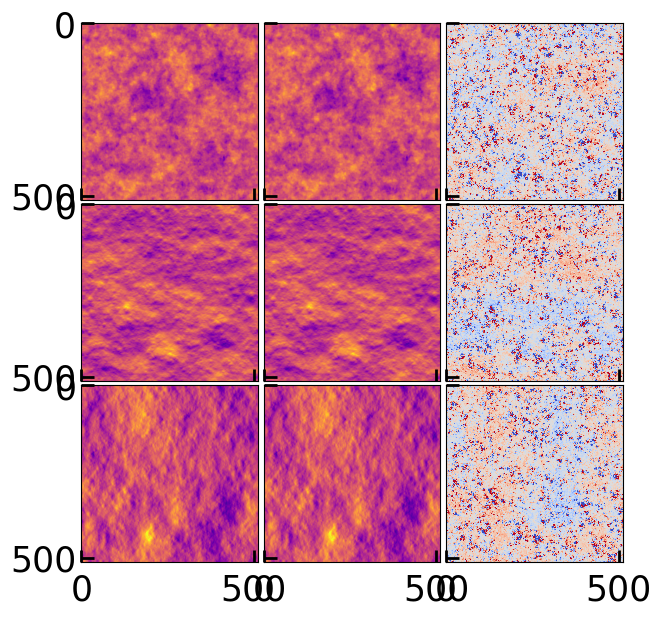

In [9]:
#
# Displacement plots
#
%matplotlib inline

fig, axs = plt.subplots(3, 3, figsize = (7,7), sharex = True, sharey=True)
plt.subplots_adjust(hspace = 0.025, wspace = 0.025)

cmap = plt.get_cmap('plasma', 256)
norm = plt.Normalize(-20, 20)
cmap2 = plt.get_cmap('coolwarm', 256)
norm2 = plt.Normalize(-0.1, 0.1)

for d in range(3) :
    axs[d, 0].imshow(sb.dis_out[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 1].imshow(dis_tgt[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 2].imshow(sb.dis_out[d,0,:,:] - dis_tgt[d,0,:,:], cmap = cmap2, norm = norm2)

In [10]:
#
# Velocity statistics
#
print(vel_tgt.min(), vel_tgt.max(), sb.vel_out.min(), sb.vel_out.max(), torch.std(vel_tgt - sb.vel_out))

tensor(-4190.0723) tensor(3989.7776) tensor(-4028.4727) tensor(3629.1284) tensor(125.1374)


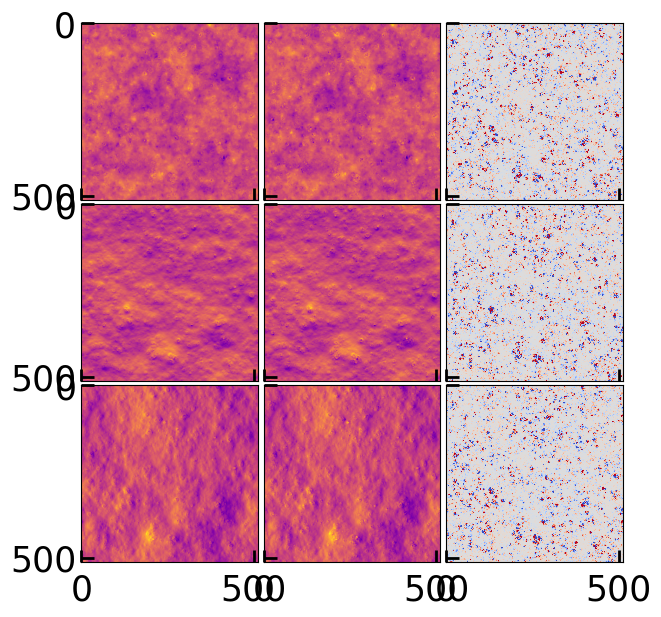

In [11]:
#
# Velocity plots
#
%matplotlib inline

fig, axs = plt.subplots(3, 3, figsize = (7,7), sharex = True, sharey=True)
plt.subplots_adjust(hspace = 0.025, wspace = 0.025)

cmap = plt.get_cmap('plasma', 256)
norm = plt.Normalize(-2000, 2000)
cmap2 = plt.get_cmap('coolwarm', 256)
norm2 = plt.Normalize(-100, 100)

for d in range(3) :
    axs[d, 0].imshow(sb.vel_out[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 1].imshow(vel_tgt[d,0,:,:], cmap = cmap, norm = norm)
    axs[d, 2].imshow(sb.vel_out[d,0,:,:] - vel_tgt[d,0,:,:], cmap = cmap2, norm = norm2)